Name : Everth Palomino Lanchipa

Se comienza descargando el archivo rows.json en la ruta /dbfs/tmp

In [0]:
%scala
import java.net.URL
import java.io.File
import org.apache.commons.io.FileUtils
import org.apache.spark.sql.SparkSession
import org.apache.spark.sql.{DataFrame, Row, SparkSession}
import org.apache.spark.sql.types.{IntegerType, StringType, StructField, StructType}
import java.util.regex.Pattern

val spark = SparkSession
  .builder()
  .appName("AppBluesmile_scala")
  .enableHiveSupport()
  .getOrCreate()

val  sc = spark.sparkContext

val tmpFile = new File("/dbfs/tmp/rows.json")
FileUtils.copyURLToFile(new URL("https://health.data.ny.gov/api/views/jxy9-yhdk/rows.json?accessType=DOWNLOAD"), tmpFile)

import java.net.URL
import java.io.File
import org.apache.commons.io.FileUtils
import org.apache.spark.sql.SparkSession
import org.apache.spark.sql.{DataFrame, Row, SparkSession}
import org.apache.spark.sql.types.{IntegerType, StringType, StructField, StructType}
import java.util.regex.Pattern
spark: org.apache.spark.sql.SparkSession = org.apache.spark.sql.SparkSession@559e02e8
sc: org.apache.spark.SparkContext = org.apache.spark.SparkContext@3070c240
tmpFile: java.io.File = /dbfs/tmp/rows.json

Question #1: Spark SQL's Native JSON Support | Question # 2 Working with Nested Data

In [0]:
# Question #1: Spark SQL's Native JSON Support | Question # 2 Working with Nested Data
from pyspark.sql.functions import explode
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import regexp_extract


spark_session = SparkSession \
    .builder \
    .appName("AppBlueSmile_pypark") \
    .enableHiveSupport() \
    .getOrCreate()

spark_session.read.json('/tmp/rows.json', multiLine=True).select(explode("data").alias("data")).registerTempTable("tb_tmp_newdata")
sqlContext.sql("SELECT data[8] AS year, data[9] AS first_name, data[10] AS country, data[11] AS sex, data[12] AS name_count FROM tb_tmp_newdata").registerTempTable("tb_tmp_babynames")
df_baby_names= spark.sql('Select * from tb_tmp_babynames')
df_baby_names.show()

+----+----------+-----------+---+----------+
year|first_name| country|sex|name_count|
+----+----------+-----------+---+----------+
2007| ZOEY| KINGS| F| 11|
2007| ZOEY| SUFFOLK| F| 6|
2007| ZOEY| MONROE| F| 6|
2007| ZOEY| ERIE| F| 9|
2007| ZOE| ULSTER| F| 5|
2007| ZOE|WESTCHESTER| F| 24|
2007| ZOE| BRONX| F| 13|
2007| ZOE| NEW YORK| F| 55|
2007| ZOE| NASSAU| F| 15|
2007| ZOE| ERIE| F| 6|
2007| ZOE| SUFFOLK| F| 14|
2007| ZOE| KINGS| F| 34|
2007| ZOE| MONROE| F| 9|
2007| ZOE| QUEENS| F| 26|
2007| ZOE| ALBANY| F| 5|
2007| ZISSY| ROCKLAND| F| 5|
2007| ZISSY| KINGS| F| 27|
2007| ZION| KINGS| M| 15|
2007| ZION| BRONX| M| 14|
2007| ZEV| ROCKLAND| M| 6|
+----+----------+-----------+---+----------+
only showing top 20 rows

Question #3: Executing Full Data Pipeline

In [0]:
#Question #3: Executing Full Data Pipelines
#Case 1 : Valida la existencia del archivo rows.json no tiene relevancia ya que en cada ejecucion consulta a la pagina y descarga el archivo.
#Case 2: Si el archivo rows.json no ha sido descargado,lo descarga la primera vez, en la siguiente iteracion ya no lo descarga.
file_exists= dbutils.fs.ls("/tmp/rows.json")
#Case 1
if  not file_exists:
    nextStep=dbutils.notebook.run(
        "extract_json", 180)
    if nextStep =="Clean":
        dbutils.notebook.run(
        "procesamiento_json", 180)
#Case 2
else:
    dbutils.notebook.run(
        "procesamiento_json", 180)

Question 4 Analyzing the Data

In [0]:
#Question 4 Analyzing the Data
df_data_input = spark_session.sql('select year,name,cnt from (select year,name,cnt ,dense_rank() OVER (PARTITION BY year ORDER BY cnt DESC) as rank from (  select substr(first_name,1,1) as name,year,count(*) as cnt from tb_tmp_babynames group by name,year) ) where rank = 1')
df_data_input.show()

+----+----+----+
year|name| cnt|
+----+----+----+
2007| A| 913|
2008| A| 936|
2009| A| 900|
2010| A| 884|
2011| A| 915|
2012| A| 880|
2013| A| 895|
2014| A|1245|
2015| A| 918|
2016| A| 935|
2017| A| 883|
2018| A| 875|
+----+----+----+

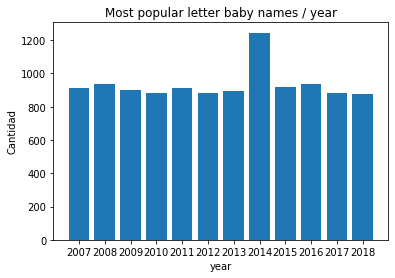

In [0]:
#Data Visualization
import matplotlib.pyplot as plt
eje_x = df_data_input.toPandas()['year'].tolist()
eje_y = df_data_input.toPandas()['cnt'].tolist()
plt.bar(eje_x, eje_y)
plt.ylabel('Cantidad')
plt.xlabel('year')
plt.title('Most popular letter baby names / year')
plt.show()

Log Processing

In [0]:
#Se lee el archivo de log que esta guardado en la ruta /FileStore/log.txt
log_raw = spark.read.text('/FileStore/log.txt')
#Definicion de expresiones regulares para extraer datos del log.
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
status_pattern = r'\s(\d{3})\s'

df_log = log_raw.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'))

df_log.show()

+--------------+--------------------+------+---------------+--------+------+
 host| timestamp|method| endpoint|protocol|status|
+--------------+--------------------+------+---------------+--------+------+
 71.19.157.174|24/Sep/2014:22:26...| GET| /error|HTTP/1.1| 404|
 10.100.200.30|25/Sep/2014:22:26...| GET| /history/apolo|HTTP/1.1| 200|
 25.100.30.450|25/Sep/2014:23:03...| GET| /ripley/tienda|HTTP/1.1| 200|
 25.100.30.450|26/Sep/2014:08:26...| GET| /ripley/banco|HTTP/1.1| 200|
 25.100.30.450|26/Sep/2014:08:30...| GET|/ripley/landing|HTTP/1.1| 200|
 10.100.200.30|27/Sep/2014:09:25...| GET| /sbp/puntos|HTTP/1.1| 200|
 71.19.157.174|27/Sep/2014:22:26...| GET| /bdt/huerut|HTTP/1.1| 200|
 71.19.157.174|27/Sep/2014:22:26...| GET| /error|HTTP/1.1| 404|
 71.19.157.174|28/Sep/2014:22:26...| GET| /error|HTTP/1.1| 404|
 71.19.157.174|29/Sep/2014:22:26...| GET| /error|HTTP/1.1| 404|
 71.19.157.174|30/Sep/2014:22:26...| GET| /error|HTTP/1.1| 404|
10.100.120.130|01/Oct/2014:22:26...| GET| /error|HTTP/1.1| 404|
 71.19.157.174|02/Oct/2014:22:26...| GET| /error|HTTP/1.1| 404|
 71.19.157.174|03/Oct/2014:22:26...| GET| /error|HTTP/1.1| 404|
 25.100.30.450|04/Oct/2014:22:26...| GET| /error|HTTP/1.1| 404|
 25.100.30.450|05/Oct/2014:22:26...| GET| /error|HTTP/1.1| 404|
 10.10.150.100|06/Oct/2014:22:26...| GET| /error|HTTP/1.1| 404|
 10.10.160.100|07/Oct/2014:22:26...| GET| /error|HTTP/1.1| 404|
 10.10.192.168|08/Oct/2014:22:26...| GET| /error|HTTP/1.1| 404|
 71.19.157.174|09/Oct/2014:22:26...| GET| /error|HTTP/1.1| 404|
+--------------+--------------------+------+---------------+--------+------+
only showing top 20 rows

<h1>CSV Parsing</h1>

Question #1: CSV Header Rows

In [0]:
%scala
//Question #1:Question #1: CSV Header Rows
val full_csv = sc.parallelize(Array(
"col_1, col_2, col_3",
"1, ABC, Foo1",
"2, ABCD, Foo2",
"3, ABCDE, Foo3",
"4, ABCDEF, Foo4",
"5, DEF, Foo5",
"6, DEFGHI, Foo6",
"7, GHI, Foo7",
"8, GHIJKL, Foo8",
"9, JKLMNO, Foo9",
"10, MNO, Foo10"))

val data_without_header = full_csv.mapPartitionsWithIndex {
  (idx, iter) => if (idx == 0) iter.drop(1) else iter 
}
data_without_header.collect()

full_csv: org.apache.spark.rdd.RDD[String] = ParallelCollectionRDD[44] at parallelize at command-3611561463677179:2
data_without_header: org.apache.spark.rdd.RDD[String] = MapPartitionsRDD[45] at mapPartitionsWithIndex at command-3611561463677179:15
res1: Array[String] = Array(1, ABC, Foo1, 2, ABCD, Foo2, 3, ABCDE, Foo3, 4, ABCDEF, Foo4, 5, DEF, Foo5, 6, DEFGHI, Foo6, 7, GHI, Foo7, 8, GHIJKL, Foo8, 9, JKLMNO, Foo9, 10, MNO, Foo10)

Question # 2 SparkSQL Dataframes

In [0]:
%scala
// Question # 2 SparkSQL Dataframes
// Se utiliza el RDD sin el header
val full_csv_row = data_without_header.map(f => {f.split(",")}).map {
      case Array(columna1, columna2,columna3) =>
        Row(columna1.toInt, columna2,columna3)
    }
val schema: StructType = StructType(Array(
      StructField("Columna1", IntegerType, true),
      StructField("Columna2", StringType, true),
      StructField("Columna3", StringType, true)
    ))
val df_full_csv = spark.createDataFrame(full_csv_row, schema)
df_full_csv.show()

+--------+--------+--------+
Columna1|Columna2|Columna3|
+--------+--------+--------+
 1| ABC| Foo1|
 2| ABCD| Foo2|
 3| ABCDE| Foo3|
 4| ABCDEF| Foo4|
 5| DEF| Foo5|
 6| DEFGHI| Foo6|
 7| GHI| Foo7|
 8| GHIJKL| Foo8|
 9| JKLMNO| Foo9|
 10| MNO| Foo10|
+--------+--------+--------+

full_csv_row: org.apache.spark.rdd.RDD[org.apache.spark.sql.Row] = MapPartitionsRDD[47] at map at command-209898474111962:3
schema: org.apache.spark.sql.types.StructType = StructType(StructField(Columna1,IntegerType,true), StructField(Columna2,StringType,true), StructField(Columna3,StringType,true))
df_full_csv: org.apache.spark.sql.DataFrame = [Columna1: int, Columna2: string ... 1 more field]

Question # 3 Parsing Pairs

In [0]:
#Genera el archivo plano para el siguiente ejercicio.
import os
file = open("/dbfs/tmp/file_KeyPairs.txt", "w")
file.write("Row-Key-001, K1, 10, A2, 20, K3, 30, B4, 42, K5, 19, C20, 20" + os.linesep)
file.write("Row-Key-002, X1, 20, Y6, 10, Z15, 35, X16, 42" + os.linesep )
file.write("Row-Key-003, L4, 30, M10, 5, N12, 38, O14, 41, P13, 8" )
file.close()

In [0]:
%scala
/* Question # 3 Parsing Pairs
Write a Spark job that processes comma-separated lines that look like the below example to pull out Key Value pairs.
Given the following data:
Row-Key-001, K1, 10, A2, 20, K3, 30, B4, 42, K5, 19, C20, 20
Row-Key-002, X1, 20, Y6, 10, Z15, 35, X16, 42
Row-Key-003, L4, 30, M10, 5, N12, 38, O14, 41, P13, 8
*/
//Nota: Para este ejercicio los datos se guardaron en un archivo plano.
val rdd_text_file = sc.textFile("/tmp/file_KeyPairs.txt")
val rdd_key_pairs = rdd_text_file.map(_.split(", ")).flatMap(x =>  x.tail.grouped(2).map(y => (x.head, y.head)))
val df_key_pairs = rdd_key_pairs.toDF("Clave","Valor")
df_key_pairs.show()

+-----------+-----+
 Clave|Valor|
+-----------+-----+
Row-Key-001| K1|
Row-Key-001| A2|
Row-Key-001| K3|
Row-Key-001| B4|
Row-Key-001| K5|
Row-Key-001| C20|
Row-Key-002| X1|
Row-Key-002| Y6|
Row-Key-002| Z15|
Row-Key-002| X16|
Row-Key-003| L4|
Row-Key-003| M10|
Row-Key-003| N12|
Row-Key-003| O14|
Row-Key-003| P13|
+-----------+-----+

rdd_text_file: org.apache.spark.rdd.RDD[String] = /FileStore/file_question3.txt MapPartitionsRDD[68] at textFile at command-2334682895293762:9
rdd_key_pairs: org.apache.spark.rdd.RDD[(String, String)] = MapPartitionsRDD[70] at flatMap at command-2334682895293762:10
df_key_pairs: org.apache.spark.sql.DataFrame = [Clave: string, Valor: string]

Question # 4 Create Tables Programmatically And Cache The Table

In [0]:
%scala
//Question # 4 Create Tables Programmatically And Cache The Table
//Utilizando el dataframe creado en la pregunta #2 (df_full_csv)  se genera una tabla utilizando  write.saveAsTable()
df_full_csv.write.saveAsTable("TB_full_csv")

at org.apache.spark.sql.DataFrameWriter.saveAsTable(DataFrameWriter.scala:704)
	at org.apache.spark.sql.DataFrameWriter.saveAsTable(DataFrameWriter.scala:625)
	at linecc3f46f141834720977663c5b54bab4337.$read$$iw$$iw$$iw$$iw$$iw$$iw$$iw.<init>(command-1210462427365216:3)
	at linecc3f46f141834720977663c5b54bab4337.$read$$iw$$iw$$iw$$iw$$iw$$iw.<init>(command-1210462427365216:55)
	at linecc3f46f141834720977663c5b54bab4337.$read$$iw$$iw$$iw$$iw$$iw.<init>(command-1210462427365216:57)
	at linecc3f46f141834720977663c5b54bab4337.$read$$iw$$iw$$iw$$iw.<init>(command-1210462427365216:59)
	at linecc3f46f141834720977663c5b54bab4337.$read$$iw$$iw$$iw.<init>(command-1210462427365216:61)
	at linecc3f46f141834720977663c5b54bab4337.$read$$iw$$iw.<init>(command-1210462427365216:63)
	at linecc3f46f141834720977663c5b54bab4337.$read$$iw.<init>(command-1210462427365216:65)
	at linecc3f46f141834720977663c5b54bab4337.$read.<init>(command-1210462427365216:67)
	at linecc3f46f141834720977663c5b54bab4337.$read$.<init>(command-1210462427365216:71)
	at linecc3f46f141834720977663c5b54bab4337.$read$.<clinit>(command-1210462427365216)
	at linecc3f46f141834720977663c5b54bab4337.$eval$.$print$lzycompute(<notebook>:7)
	at linecc3f46f141834720977663c5b54bab4337.$eval$.$print(<notebook>:6)
	at linecc3f46f141834720977663c5b54bab4337.$eval.$print(<notebook>)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at scala.tools.nsc.interpreter.IMain$ReadEvalPrint.call(IMain.scala:745)
	at scala.tools.nsc.interpreter.IMain$Request.loadAndRun(IMain.scala:1021)
	at scala.tools.nsc.interpreter.IMain.$anonfun$interpret$1(IMain.scala:574)
	at scala.reflect.internal.util.ScalaClassLoader.asContext(ScalaClassLoader.scala:41)
	at scala.reflect.internal.util.ScalaClassLoader.asContext$(ScalaClassLoader.scala:37)
	at scala.reflect.internal.util.AbstractFileClassLoader.asContext(AbstractFileClassLoader.scala:41)
	at scala.tools.nsc.interpreter.IMain.loadAndRunReq$1(IMain.scala:573)
	at scala.tools.nsc.interpreter.IMain.interpret(IMain.scala:600)
	at scala.tools.nsc.interpreter.IMain.interpret(IMain.scala:570)
	at com.databricks.backend.daemon.driver.DriverILoop.execute(DriverILoop.scala:219)
	at com.databricks.backend.daemon.driver.ScalaDriverLocal.$anonfun$repl$1(ScalaDriverLocal.scala:204)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.backend.daemon.driver.DriverLocal$TrapExitInternal$.trapExit(DriverLocal.scala:789)
	at com.databricks.backend.daemon.driver.DriverLocal$TrapExit$.apply(DriverLocal.scala:742)
	at com.databricks.backend.daemon.driver.ScalaDriverLocal.repl(ScalaDriverLocal.scala:204)
	at com.databricks.backend.daemon.driver.DriverLocal.$anonfun$execute$10(DriverLocal.scala:431)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:239)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:234)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:231)
	at com.databricks.backend.daemon.driver.DriverLocal.withAttributionContext(DriverLocal.scala:48)
	at com.databricks.logging.UsageLogging.withAttributionTags(UsageLogging.scala:276)
	at com.databricks.logging.UsageLogging.withAttributionTags$(UsageLogging.scala:269)
	at com.databricks.backend.daemon.driver.DriverLocal.withAttributionTags(DriverLocal.scala:48)
	at com.databricks.backend.daemon.driver.DriverLocal.execute(DriverLocal.scala:408)
	at com.databricks.backend.daemon.driver.DriverWrapper.$anonfun$tryExecutingCommand$1(DriverWrapper.scala:653)
	at scala.util.Try$.apply(Try.scala:213)
	at com.databricks.backend.daemon.driver.DriverWrapper.tryExecutingCommand(DriverWrapper.

In [0]:
%sql
select * from TB_full_csv

Columna1,Columna2,Columna3
1,ABC,Foo1
8,GHIJKL,Foo8
9,JKLMNO,Foo9
10,MNO,Foo10
2,ABCD,Foo2
3,ABCDE,Foo3
4,ABCDEF,Foo4
5,DEF,Foo5
6,DEFGHI,Foo6
7,GHI,Foo7


Temporary Tables<br>
<li>Within each Spark cluster, temporary tables registered in the sqlContext with DataFrame.registerTempTable will also be shared across the notebooks attached to that Databricks cluster
<li>Run someDataFrame.registerTempTable(TEMP_TABLE_NAME) to give register a table.
<li>These tables will not be visible in the left-hand menu, but can be accessed by name in SQL and DataFrames.

In [0]:
%scala
//Temporary Tables en Question #1 se crean dos tablas temporales que no son almacenadas en el workspace de databricks, pero si pueden ser consultadas en el contexto de spark.
//Se utiliza el dataframe creado en la pregunta 3
df_key_pairs.createOrReplaceTempView("tb_tmp_key_pairs")

In [0]:
%sql
/*De la tabla creada anteriormente es posible consultarla con sql, esta tabla no se guarda en el espacio de trabajo de databricks*/
Select * from tb_tmp_key_pairs;

Clave,Valor
Row-Key-001,K1
Row-Key-001,A2
Row-Key-001,K3
Row-Key-001,B4
Row-Key-001,K5
Row-Key-001,C20
Row-Key-002,X1
Row-Key-002,Y6
Row-Key-002,Z15
Row-Key-002,X16


In [0]:
#En este caso se trabaja con pyspark el mismo ejercicio, a diferencia del caso anterior que es desarrollado en scala.
sqlContext.sql("select * from tb_full_csv").registerTempTable("tb_tmp_full_csv")
df_temp_full_csv = spark.sql("select * from tb_tmp_full_csv")
df_temp_full_csv.show()

+--------+--------+--------+
Columna1|Columna2|Columna3|
+--------+--------+--------+
 1| ABC| Foo1|
 8| GHIJKL| Foo8|
 9| JKLMNO| Foo9|
 10| MNO| Foo10|
 2| ABCD| Foo2|
 3| ABCDE| Foo3|
 4| ABCDEF| Foo4|
 5| DEF| Foo5|
 6| DEFGHI| Foo6|
 7| GHI| Foo7|
+--------+--------+--------+

<h1>Others</h1>

1.	Given a data set in raw text storage format. What other data storage format can you suggest optimizing the performance of a Spark workload if we were to frequently scan and read this dataset. Explain why you decide to go with this approach?
<br>
As a data storage format, I would use parquet, it is a format that handles different forms of compression in storage and the way in which the data is saved is columnar, which optimizes data reading.

2.	You are given to design a streaming data pipeline on AWS, consuming the data in the form of JSON events from an external producer. The customers consuming this data from the AWS endpoint you provide has a requirement that this data set be structured/normalised and easier to use. What are your tools of choice to design this streaming pipeline, how will you ensure the costs don’t surge, and how will you fulfil the customer’s request?
<br>
For reading the events of the producer I would use AWS lambda (python) to read and process the events, for storage I would use AWS RDS Aurora which are relational databases that allow  to save the normalized and structured data There is not a license cost, only paid for the infrastructure on which the database is implemented and it is managed by AWS, for the information consumption endpoint it would be implemented with API Gateway and lambda to build an API Rest service in python or node code. js.